<a href="https://colab.research.google.com/github/payalnpatel/payalnpatel.github.io/blob/master/ABD_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Install PySpark Dependencies**

In [1]:
!rm spark-2.4.5-bin-hadoop2.7.tgz
!wget --no-cookies --no-check-certificate https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar zxvf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 204kB 46.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=cd02e54c6cb1b6ac00a11c31b8a83ec4efd1e9cd999aa3a333fdd498da58171a
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


### **Load Data**

In [2]:
!wget https://raw.githubusercontent.com/zaratsian/Datasets/master/banking_attrition.csv

--2020-03-26 17:03:01--  https://raw.githubusercontent.com/zaratsian/Datasets/master/banking_attrition.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4021593 (3.8M) [text/plain]
Saving to: ‘banking_attrition.csv’

banking_attrition.c 100%[===================>]   3.83M  --.-KB/s    in 0.1s    

2020-03-26 17:03:01 (36.6 MB/s) - ‘banking_attrition.csv’ saved [4021593/4021593]



In [33]:
!wget https://raw.githubusercontent.com/payalnpatel/Data/master/banking_attrition.csv

--2020-03-26 18:01:07--  https://raw.githubusercontent.com/payalnpatel/Data/master/banking_attrition.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4021593 (3.8M) [text/plain]
Saving to: ‘banking_attrition.csv.1’

banking_attrition.c 100%[===================>]   3.83M  --.-KB/s    in 0.1s    

2020-03-26 18:01:08 (36.9 MB/s) - ‘banking_attrition.csv.1’ saved [4021593/4021593]



### **Import Python/Spark Libraries**

In [0]:

import os
os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import datetime, time
import re, random, sys

# Note - Not all of these will be used, but I've added them for your reference as a "getting started"
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, ArrayType, IntegerType, StringType, FloatType, LongType, DateType
from pyspark.sql.functions import struct, array, lit, monotonically_increasing_id, col, expr, when, concat, udf, split, size, lag, count, isnull
from pyspark.sql import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import GBTRegressor, LinearRegression, GeneralizedLinearRegression, RandomForestRegressor
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

In [0]:
import matplotlib.pyplot as plt

### **Create Spark Session**

In [0]:
spark = SparkSession.builder.appName("Spark ML Assignment").master("local[*]").getOrCreate()

### **Load CSV Data Into Spark DataFrame**

In [0]:
rawdata = spark.read.csv('banking_attrition.csv', header=True, inferSchema=True)

In [18]:
print( '\nTotal Records: ' + str(rawdata.count()) + '\n')


Total Records: 45211



In [17]:
print('\r\nTotal Records: ' + str(rawdata.count()) + '\r\n\r\n')


Total Records: 45211




In [21]:
rawdata.columns

['uid',
 'age',
 'age_group',
 'profession',
 'marital_status',
 'education',
 'default',
 'housing',
 'loan',
 'gender',
 'balance',
 'membership',
 'charges',
 'customer_contacts',
 'attrition']

### **Data Exploration**

In [22]:
rawdata.groupBy('gender').avg().collect()

[Row(gender='female', avg(uid)=1022624.9466671876, avg(age)=40.27791669922638, avg(charges)=142.11881691021333, avg(customer_contacts)=2.0891224505743535, avg(attrition)=0.31288583261701963),
 Row(gender='male', avg(uid)=1022581.2805729724, avg(age)=42.08854564918183, avg(charges)=99.83208441657746, avg(customer_contacts)=1.7560279349543764, avg(attrition)=0.11173981750522506)]

In [23]:
rawdata.groupBy("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|female|25594|
|  male|19617|
+------+-----+



In [24]:
rawdata.groupBy("membership").count().show()

+----------+-----+
|membership|count|
+----------+-----+
|    silver|12840|
|      gold| 9969|
|  platinum|22402|
+----------+-----+



UsageError: Line magic function `%matplot` not found.


<Figure size 432x288 with 0 Axes>

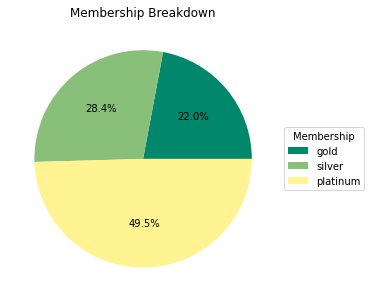

In [28]:
#Species breakdown in training dataset  
membership_dist = rawdata.groupBy('membership').count().orderBy('count').toPandas()
plt.clf()
labels = [f"{membership}" for membership in membership_dist['membership']]
obs = [num_obs for num_obs in membership_dist['count']]
colors = ['#00876c', '#89c079', '#fff392']
fig, ax = plt.subplots(figsize=(8,5))
w,a,b = ax.pie(obs, autopct='%1.1f%%', colors=colors)
plt.title('Membership Breakdown')
ax.legend(w, labels, title="Membership", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
%matplot plt

### **Split the Spark DataFrame Into Train and Test**

In [0]:
train, test   = rawdata.randomSplit([0.8, 0.2], seed=12345)

In [30]:
train.count()

36030

In [32]:
test.count()

9181

### **Feature Engineering**

### **Fit/Train ML Model**

### **Make Predictions**

### **Evaluate Model Against Test DataFrame**